In [9]:
# Currently pypulseq 1.4 crashes when loading some seq files
!pip install pypulseq==1.3.1post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!pip install git+https://github.com/imr-framework/pypulseq.git@dev &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null

Syntaxfehler.
Syntaxfehler.
Syntaxfehler.
Syntaxfehler.
Syntaxfehler.


(mr0_upload_seq)=
# Upload own seq files
Here  you can upload and simulate own seq files.
Some tested seq-files can be found [here](https://drive.google.com/drive/folders/1EfQRpSXypv3O-t8qn0C6m16xlya_B2Pg). You can download them and then reupload one of these, or an own own seq-file and then simulate them in a brain phantom.


In [10]:
#@title 1. Imports
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
import util

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [11]:
#@title 2. upload seq file
try:
    # This only runs on google colab
    from google.colab import files
    uploaded = files.upload()
    seq_file = next(iter(uploaded))
except ImportError:
    # Local example file for doc build
    seq_file = "tse_pypulseq.seq"

seq = pp.Sequence()
seq.read(seq_file)

In [33]:
#@title 3. Set up spin system and simulate sequence
plot_phantom = False #@param {type:"boolean"}
pixel_phantom = False #@param {type:"boolean"}
sz = [64, 64]

print('load phantom')
if pixel_phantom:
    obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.25, -0.25, 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
else:
    obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
    brain_phantom_res = 64 #@param {type:"slider", min:16, max:128, step:16}
    obj_p = obj_p.interpolate(brain_phantom_res, brain_phantom_res, 1)
    obj_p.B0[:] = 0
    # obj_p.D[:] = 0

if plot_phantom:
    obj_p.plot()
obj_p = obj_p.build(use_SI_FoV=True)
print(obj_p.fov)

print('simulate (2D) \n' + seq_file)

seq0 = mr0.Sequence.import_file(seq_file, exact_trajectories=False)

# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p)

load phantom
tensor([0.2000, 0.2000, 0.0080])
simulate (2D) 
tse_pypulseq.seq
Calculating repetition 44 / 153

D:\repos\MRzero-Core\python\MRzeroCore\phantom\voxel_grid_phantom.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / fov,


Calculating repetition 153 / 153 - done


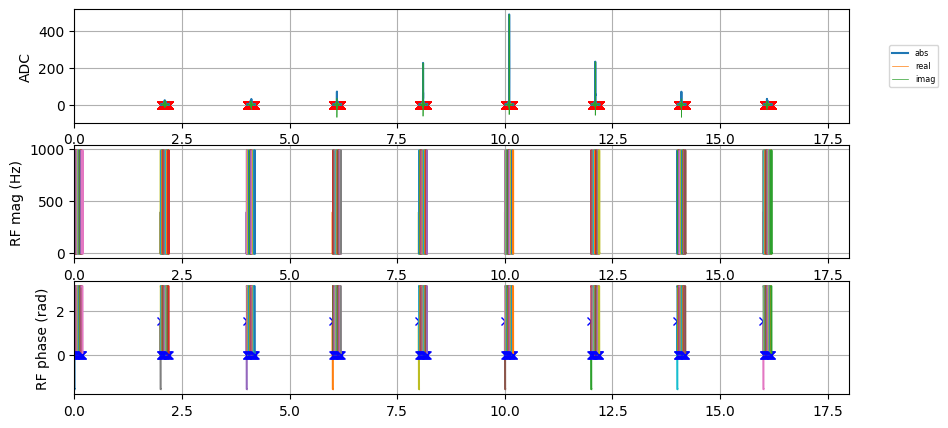

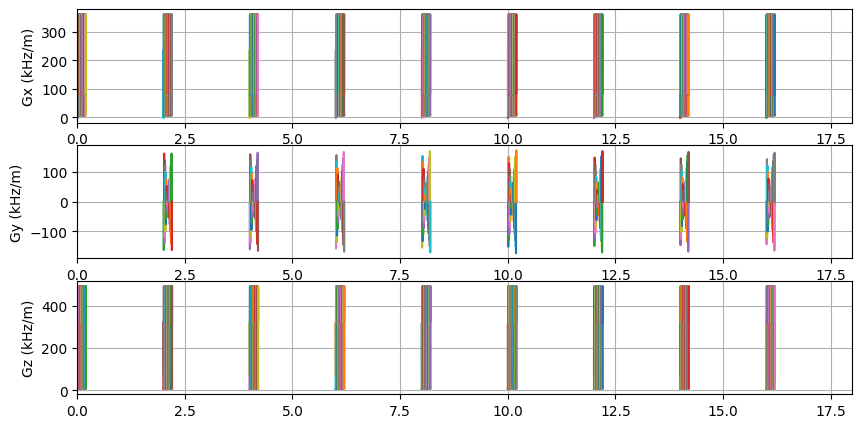

reconstruct and plot


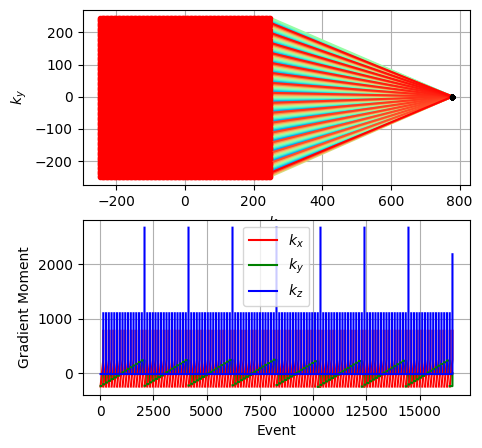

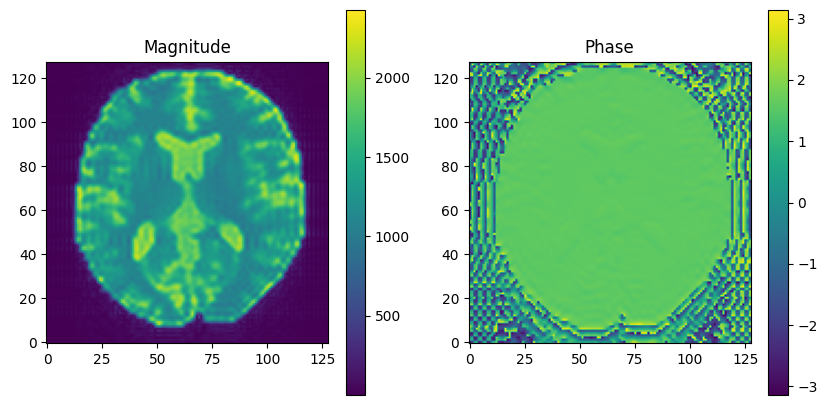

In [32]:
#@title 3. Plot sequence and reconstructed image

sp_adc, t_adc = util.pulseq_plot(seq=seq,signal=signal.numpy())

# Unfortunately, we need to limit the resolution as reco_adjoint is very RAM-hungy
print('reconstruct and plot')
seq0.plot_kspace_trajectory()

reco = mr0.reco_adjoint(signal, seq0.get_kspace(), resolution=(128, 128, 1), FOV=(0.2, 0.2, 1))
plt.figure()
plt.subplot(121)
plt.title("Magnitude")
plt.imshow(reco[:, :, 0].T.abs(), origin="lower")
plt.colorbar()
plt.subplot(122)
plt.title("Phase")
plt.imshow(reco[:, :, 0].T.angle(), origin="lower", vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.show()